# 02 DATA PREPROCESSING

## 1. Setups and Imports

In [2]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils import save_dataframe
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE



In [3]:
#load data
EDA_PATH = "../data/eda_output.csv"

df = pd.read_csv(EDA_PATH)
print(f"Loaded DataFrame: {EDA_PATH}")
print(f"Shape: {df.shape}")
print(f"Head: {df.head}")


Loaded DataFrame: ../data/eda_output.csv
Shape: (649, 33)
Head: <bound method NDFrame.head of     school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F   19       R     GT3       T     2     3  services     other   
645     MS   F   18       U     LE3       T     3     1   teacher  services   
646     MS   F   18       U     GT3       T     1     1     other     other   
647     MS   M   17       U     LE3       T     3     1  services  services   
648     MS   M   18       R     LE3  

## 2. Create Binary Target

In [4]:
# Students with final grade < 10 are considered at risk
df["at_risk"] = (df["G3"] < 10).astype(int)

num_at_risk = df["at_risk"].sum()
percentage_at_risk = (num_at_risk / len(df)) * 100

# Dropping grades
df = df.drop(columns=["G1", "G2", "G3"])
print(f"Total students: {len(df)}")
print(f"At-risk students: {num_at_risk} ({percentage_at_risk:.2f}%)")

Total students: 649
At-risk students: 100 (15.41%)


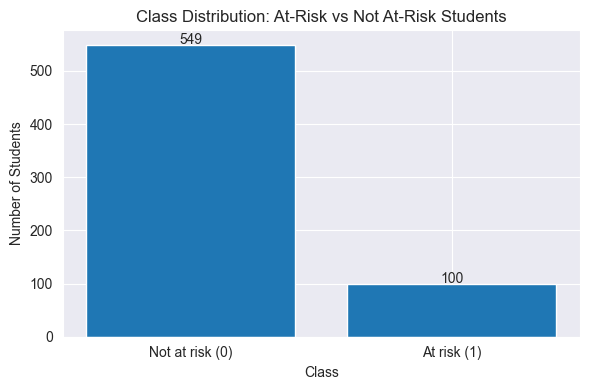

In [5]:
# Count class distribution
class_counts = df["at_risk"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(["Not at risk (0)", "At risk (1)"], class_counts)

plt.title("Class Distribution: At-Risk vs Not At-Risk Students")
plt.xlabel("Class")
plt.ylabel("Number of Students")

# Annotate bars with counts
for i, count in enumerate(class_counts):
    plt.text(i, count + 1, str(count), ha='center')

plt.tight_layout()
plt.show()


## 3. Feature Engineering
Adding some custom columns.

In [6]:
# Combine alcohol consumption into a single mean feature
df["alc_mean"] = (df["Dalc"] + df["Walc"]) / 2

# Parental education average
df["parent_edu_mean"] = (df["Medu"] + df["Fedu"]) / 2

# High absence flag (binary)
median_absences = df["absences"].median()
df["high_absentee"] = (df["absences"] > median_absences).astype(int)


## 4. Encode Categorical Variables

In [7]:
categorical_col = df.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns to encode:")
print(categorical_col)

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_col, drop_first=True)

Categorical columns to encode:
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


## 5. Scale Numeric Variables

In [8]:
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove("at_risk")

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])


## 6. Handle Outliers

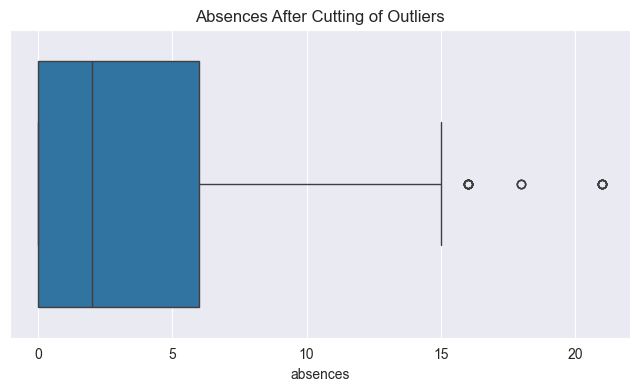

In [9]:
low, high = df["absences"].quantile([0.01, 0.99])
df["absences"] = df["absences"].clip(lower=low, upper=high)

plt.figure(figsize=(8, 4))
sns.boxplot(x=df["absences"])
plt.title("Absences After Cutting of Outliers")
plt.show()


## 7. Feature Selection

In [10]:

X = df_encoded.drop(columns=["at_risk"]) # dropping grades
y = df_encoded["at_risk"]

# Apply SelectKBest (keep top 20 features)
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

print("\n Top 20 Selected Features:")
for i, f in enumerate(selected_features, 1):
    print(f"{i:2d}. {f}")

# Create reduced DataFrame
df_selected = df_encoded[selected_features + ["at_risk"]]


 Top 20 Selected Features:
 1. age
 2. Medu
 3. Fedu
 4. studytime
 5. failures
 6. freetime
 7. Dalc
 8. Walc
 9. absences
10. alc_mean
11. parent_edu_mean
12. school_MS
13. sex_M
14. address_U
15. Mjob_teacher
16. reason_other
17. reason_reputation
18. higher_yes
19. internet_yes
20. romantic_yes


## 8. Train/Test Split

In [11]:
X = df_selected.drop(columns=["at_risk"])
y = df_selected["at_risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [12]:
# Imbalance data at-risk vs. not at-risk
print("\n" + "="*30)
print(f"Original training shape: {X_train.shape}")
print(f"Original at-risk count: {y_train.sum()}")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE *only* on the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nNew SMOTE training shape: {X_train_smote.shape}")
print(f"New at-risk count: {y_train_smote.sum()}")
print("="*30)


Original training shape: (454, 20)
Original at-risk count: 70


ModuleNotFoundError: No module named 'imblearn'

In [18]:
#save processed data

train_df = pd.concat([pd.DataFrame(X_train_smote, columns=X_train.columns), 
                      pd.DataFrame(y_train_smote, columns=['at_risk'])], axis=1)

test_df = pd.concat([X_test, y_test], axis=1) # Test set stays the same!
full_df = pd.concat([X, y], axis=1)

save_dataframe(train_df, "train_processed")
save_dataframe(test_df, "test_processed")
save_dataframe(full_df, "processed_full")


File already exists. Overwriting dhbw-3rd-semester-data-science-capstone-project/data/train_processed.csv
DataFrame saved successfully.
File already exists. Overwriting dhbw-3rd-semester-data-science-capstone-project/data/test_processed.csv
DataFrame saved successfully.
File already exists. Overwriting dhbw-3rd-semester-data-science-capstone-project/data/processed_full.csv
DataFrame saved successfully.


### Summary
1. **Loaded EDA Output**
2. **Created Target Variable**: Defined a binary target `at_risk` where students with `G3 < 10` are labeled as **1 (at risk)**, and others as **0 (passed)**.
3. **Encoding Categorical Variables**: Converted categorical columns into numeric form using one-hot encoding with `pd.get_dummies()`.
4. **Feature Scaling**
5. **Handled Outliers**
6. **Feature Engineering**: Created new, meaningful features
7. **Train/Test Split**
8. **Saved Final Outputs**



